# Project 8. Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Цель работы
прогнозирование стоимости автомобиля по характеристикам

## Задачи работы
применить на практике навыки работы с:
* моделями NLP (natural language processing)
* multi-input нейронными сетями
* CNN для анализа изображений
* моделей ML
* ансамблированием моделей



## Подготовка к работе

### код для среды Google Colab

In [1]:
!chmod 600 kaggle.json
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -U -q kaggle==1.5.8
!kaggle competitions download -c sf-dst-car-price-prediction-part2 --force
!unzip -oq sf-dst-car-price-prediction-part2.zip -d ./input/

     |████████████████████████████████| 59 kB 3.0 MB/s 
 97% 193M/199M [00:10<00:00, 18.1MB/s]
100% 199M/199M [00:10<00:00, 19.6MB/s]


In [4]:
# use in Colab
MODEL_PATH = '/content/drive/MyDrive/'

# use on local notebooks
# MODEL_PATH = './'

### Загрузка библиотек

In [5]:
#аугментации изображений
!pip install albumentations catboost -q

     |████████████████████████████████| 76.3 MB 1.1 MB/s 
     |████████████████████████████████| 631 kB 62.9 MB/s 


In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import albumentations

# plt
import matplotlib.pyplot as plt
import seaborn as sns
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

plt.rcParams['figure.figsize'] = 12, 5

In [7]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.12 (default, Sep 10 2021, 00:21:48) 
Numpy        : 1.19.5
Tensorflow   : 2.7.0


In [8]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [9]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 73
np.random.seed(RANDOM_SEED)

In [10]:
!pip freeze > requirements.txt

## Загрузка данных

In [11]:
DATA_DIR = './input/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [13]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - <s>категориальный</s> бинарный
* Привод - категориальный
* Руль - <s>категориальный</s> бинарный

## Model 1. Наивная модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [14]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [15]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 20.55%


## EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

In [16]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['is_train'] = 1 # помечаем где у нас трейн
test['is_train'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [17]:
data.columns = ['body_type', 'brand', 'color', 'description', 'volume',
                'power', 'fuel', 'mileage', 'model_date', 'model_info', 'name',
                'doors', 'production_date', 'sell_id', 'config',
                'transmission', 'owners', 'owned', 'docs', 'drive', 'steering',
                'is_train', 'price']

### Целевая переменная - **цена** (`price`)

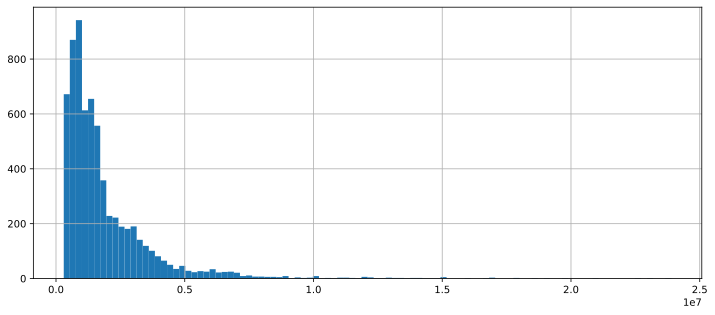

In [18]:
train_price = data[data.is_train == 1].price
train_price.hist(bins=100)

{'boxes': [<matplotlib.lines.Line2D at 0x7f798a6d87d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f798a6dc7d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f798a6e3810>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f798a6e32d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f798a6d8d10>,
  <matplotlib.lines.Line2D at 0x7f798a6dc290>]}

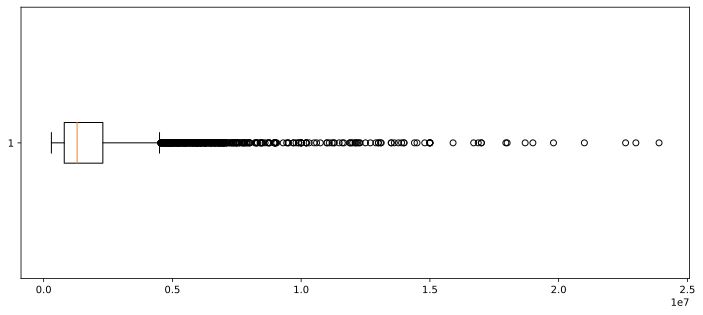

In [19]:
plt.boxplot(train_price, vert=False)

Налицо экспоненциальное распределение и куча выбросов. Для начала проверим, не являются ли выбросы ошибками.

In [20]:
h_price = 1.5 * train_price.quantile(0.75)
data[data.price > h_price].sample(5)

,body_type,brand,color,description,volume,power,fuel,mileage,model_date,model_info,name,doors,production_date,sell_id,config,transmission,owners,owned,docs,drive,steering,is_train,price
7013,седан,BMW,чёрный,"В продаже автомобили от компании АО ABTODOM, о...",3.0 LTR,400 N12,дизель,50000,2015,7ER,750d xDrive 3.0d AT (400 л.с.) 4WD,4,2017,1099588518,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый,1,3980000.0
3601,внедорожник 5 дв.,BMW,серый,Stage 3 (425+ л.с) (Турбина+Интеркуллер+выхлоп...,3.0 LTR,249 N12,дизель,60100,2013,X5,30d 3.0d AT (249 л.с.) 4WD,5,2017,1100115226,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,1 владелец,3 года,Оригинал,полный,Левый,1,4000000.0
3725,седан,BMW,чёрный,Внимание! Только для клиентов AVILON Автомобил...,4.4 LTR,450 N12,бензин,12184,2015,7ER,750i 4.4 AT (450 л.с.),4,2017,1099389104,SEDAN AUTOMATIC 4.4,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,3470000.0
5638,седан,BMW,чёрный,Безупречное состояние. На гарантии. Комплектац...,3.0 LTR,400 N12,дизель,72000,2015,7ER,750Ld xDrive 3.0d AT (400 л.с.) 4WD,4,2017,1098535474,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,1 год и 9 месяцев,Оригинал,полный,Левый,1,3590000.0
1904,седан,MERCEDES,чёрный,В салоны ставить не буду не звоните. Торг умес...,3.0 LTR,333 N12,бензин,124000,2016,E_KLASSE,400 3.0 AT (333 л.с.) 4WD,4,2017,1100160710,SEDAN AUTOMATIC 3.0,автоматическая,1 владелец,3 года,Оригинал,полный,Левый,1,3500000.0


Нет, дорогие машины дорого стоят. Логарифмируем цену. Заодно предварительно поделим цены на 1000, т.к. в большинстве случаев цена кратна 1000.

чтобы не сломалось наше предсказание, сразу объявим метод восстановления цены. 

Новую целевую переменную для удобства сохраним в отдельный столбец

In [21]:
data['price_log'] = np.log(1 + (data.price / 1000)) # zero-safe

def predict_price(y_pred):
    return np.round(np.exp(y_pred) - 1) * 1000

### Мощность двигателя (`power`)

In [22]:
data.power.unique()

array(['220 N12', '313 N12', '218 N12', '136 N12', '190 N12', '340 N12',
       '245 N12', '316 N12', '170 N12', '160 N12', '231 N12', '388 N12',
       '180 N12', '367 N12', '115 N12', '184 N12', '177 N12', '455 N12',
       '422 N12', '163 N12', '249 N12', '272 N12', '224 N12', '122 N12',
       '557 N12', '333 N12', '306 N12', '156 N12', '150 N12', '264 N12',
       '450 N12', '555 N12', '407 N12', '130 N12', '400 N12', '204 N12',
       '469 N12', '192 N12', '210 N12', '211 N12', '239 N12', '200 N12',
       '350 N12', '420 N12', '300 N12', '381 N12', '265 N12', '258 N12',
       '390 N12', '197 N12', '120 N12', '544 N12', '193 N12', '235 N12',
       '233 N12', '394 N12', '355 N12', '421 N12', '320 N12', '585 N12',
       '105 N12', '280 N12', '194 N12', '132 N12', '639 N12', '250 N12',
       '335 N12', '510 N12', '116 N12', '360 N12', '238 N12', '225 N12',
       '625 N12', '571 N12', '507 N12', '286 N12', '372 N12', '575 N12',
       '408 N12', '310 N12', '354 N12', '255 N12', 

Похоже, все значения - числа, к которым приписали '` N12`'. Проверим и исправим

In [23]:
data.power.apply(lambda s: s[-4:]).nunique()
# должно быть 1

1

In [24]:
data.power = pd.to_numeric(data.power.apply(lambda s: s[:-4]), errors='coerce')
data.power.unique()

array([220, 313, 218, 136, 190, 340, 245, 316, 170, 160, 231, 388, 180,
       367, 115, 184, 177, 455, 422, 163, 249, 272, 224, 122, 557, 333,
       306, 156, 150, 264, 450, 555, 407, 130, 400, 204, 469, 192, 210,
       211, 239, 200, 350, 420, 300, 381, 265, 258, 390, 197, 120, 544,
       193, 235, 233, 394, 355, 421, 320, 585, 105, 280, 194, 132, 639,
       250, 335, 510, 116, 360, 238, 225, 625, 571, 507, 286, 372, 575,
       408, 310, 354, 255, 435, 525, 591, 109, 462, 143, 279, 487, 560,
       125, 609, 102, 290, 296, 230, 326, 269, 445, 580, 370, 401, 129,
       500, 270, 140, 110, 476, 166, 321, 626, 252, 612, 113, 101, 240,
       605, 700, 133,  95, 558, 271,  82, 530, 329, 517, 118, 430, 260,
       550, 299, 610, 402, 330, 600, 292, 431, 520, 100, 242, 457,  75,
       256, 347, 223, 215,  98, 114, 480, 234, 514, 165, 174])

### Объем двигателя (`volume`)

In [25]:
data.volume.unique()

array(['3.0 LTR', '2.5 LTR', '2.0 LTR', '3.5 LTR', '1.8 LTR', '2.2 LTR',
       '5.5 LTR', '4.8 LTR', '1.6 LTR', '4.7 LTR', '4.0 LTR', '1.5 LTR',
       '2.4 LTR', '1.4 LTR', '2.1 LTR', '5.2 LTR', '4.4 LTR', '2.8 LTR',
       '4.2 LTR', '3.2 LTR', '6.0 LTR', '3.7 LTR', '5.0 LTR', '1.2 LTR',
       '3.6 LTR', '2.3 LTR', '6.2 LTR', '1.7 LTR', '1.3 LTR', '5.4 LTR',
       '3.1 LTR', '2.6 LTR', '3.8 LTR', '4.1 LTR', '2.9 LTR', '6.6 LTR',
       '5.9 LTR', 'undefined LTR', '2.7 LTR', '0.7 LTR', '1.9 LTR',
       '4.3 LTR', '5.8 LTR', '4.9 LTR', '3.4 LTR', '6.3 LTR', '5.6 LTR',
       '4.6 LTR'], dtype=object)

Похоже, что все значения заканчиваются на `' LTR'`. Проверяем:

In [26]:
data.volume.apply(lambda s: s[-4:]).nunique()
# должно быть 1

1

In [27]:
data['volume_val'] = pd.to_numeric(data.volume.apply(lambda s: s[:-4]), errors='coerce')
data.volume_val.unique()

array([3. , 2.5, 2. , 3.5, 1.8, 2.2, 5.5, 4.8, 1.6, 4.7, 4. , 1.5, 2.4,
       1.4, 2.1, 5.2, 4.4, 2.8, 4.2, 3.2, 6. , 3.7, 5. , 1.2, 3.6, 2.3,
       6.2, 1.7, 1.3, 5.4, 3.1, 2.6, 3.8, 4.1, 2.9, 6.6, 5.9, nan, 2.7,
       0.7, 1.9, 4.3, 5.8, 4.9, 3.4, 6.3, 5.6, 4.6])

Есть модели с необпределенным (`NAN`) значением объема двигателя. Что это за модели?

In [28]:
data[data.volume_val.isna()].sample()

,body_type,brand,color,description,volume,power,fuel,mileage,model_date,model_info,name,doors,production_date,sell_id,config,transmission,owners,owned,docs,drive,steering,is_train,price,price_log,volume_val
7533,хэтчбек 5 дв.,BMW,белый,В наличии! Автомобиль куплен в США! Комплектац...,undefined LTR,170,электро,35810,2013,I3,Electro AT (126 кВт),5,2016,1100153696,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,1690000.0,7.433075,NaN


Это электрокары. Нестрашно, но надо эти пропуски заполнить. Можно проставить 0, но мне кажется, лучше примерно прикинуть по мощности этих электрокаров, какой у них был бы эквивалентный объем двигателя

(8347, 1)


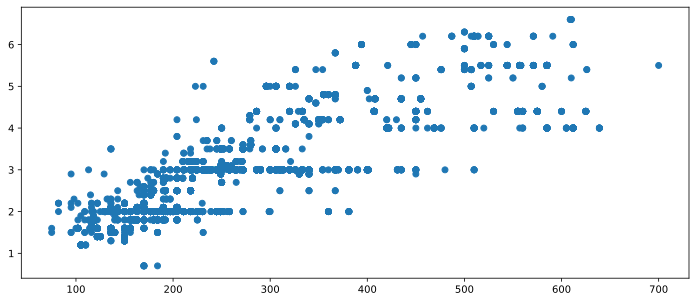

In [29]:
from sklearn.linear_model import LinearRegression
lg_data = data[data.volume_val.notna()]
lg_X = lg_data[['power']]
lg_Y = lg_data.volume_val
print(lg_X.shape)
plt.scatter(lg_X, lg_Y)

Зависимость видна, хотя и не идеально линейная. Мне кажется, в любом случае лучше, чем просто 0 поставить

In [30]:
lr = LinearRegression().fit(lg_X, lg_Y)
print(lr.score(lg_X, lg_Y))
print(lr.coef_, lr.intercept_)

0.7401770462166835
[0.00834277] 0.6468651096356379


In [31]:
nan_data = data[data.volume_val.isna()]
nan_idx = nan_data.index
data.loc[nan_idx,['volume_val']] = np.round(lr.predict(nan_data[['power']]), 1)
data.iloc[nan_idx].sample(3)


,body_type,brand,color,description,volume,power,fuel,mileage,model_date,model_info,name,doors,production_date,sell_id,config,transmission,owners,owned,docs,drive,steering,is_train,price,price_log,volume_val
3967,хэтчбек 5 дв.,BMW,чёрный,"Автомобиль в наличии Москве , с ПТС , производ...",undefined LTR,184,электро,9000,2017,I3,S Electro AT (136 кВт),5,2019,1100083262,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,2719000.0,7.908387,2.2
7533,хэтчбек 5 дв.,BMW,белый,В наличии! Автомобиль куплен в США! Комплектац...,undefined LTR,170,электро,35810,2013,I3,Electro AT (126 кВт),5,2016,1100153696,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,1690000.0,7.433075,2.1
1005,хэтчбек 5 дв.,BMW,серебристый,.,undefined LTR,170,электро,89942,2013,I3,Electro AT (126 кВт),5,2014,1100166318,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,0,0.0,0.000000,2.1


<s>тут надо отметить, что код закомментирован, поскольку использование признака `volume` в качестве категориального улучшает MAPE по сравнению с использованием его же в качестве числового признака</s>

### ПТС (`docs`) и Руль (`steering`)

In [32]:
data.docs = data.docs.apply(lambda s: s == 'Оригинал').astype('int')
data.steering = data.steering.apply(lambda s: s == 'Левый').astype('int')

### Владельцы (`owners`) и владение (`owned`)

In [33]:
data.owners.unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца', nan],
      dtype=object)

In [34]:
data.owners = data.owners.fillna('1').apply(lambda s: s[0]).astype('int')

Распарсим срок владения и переведем его в дробные годы.

In [35]:
months = data.owned.str.extract(r'(\d{1,2})\sмесяц').astype('float')
years = data.owned.str.extract(r'(\d{1,2})\s(?:лет|год)').astype('float')

data.owned = np.round(years + (months / 12), 3)
data.owned.isna().sum()

5986

Много пропусков в графе "владение". За неимением других данных, предположим, что владение происходило сразу после продажи. Т.е. примерный срок владения вычислим как разность между будущим годом (2022) и годом производства

In [36]:
nan_data = data[data.owned.isna()]
nan_idx = nan_data.index
data.loc[nan_idx, ['owned']] = 2022 - data.iloc[nan_idx].production_date

### Тип кузова (`body_type`)

In [37]:
data.body_type = data.body_type.apply(lambda s: s.split(' ')[0])
data.body_type.unique()

array(['универсал', 'купе', 'седан', 'внедорожник', 'родстер', 'лифтбек',
       'хэтчбек', 'купе-хардтоп', 'минивэн', 'кабриолет', 'пикап',
       'компактвэн', 'лимузин'], dtype=object)

Посмотрим, как выглядят распределения числовых признаков:

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   body_type        8353 non-null   object 
 1   brand            8353 non-null   object 
 2   color            8353 non-null   object 
 3   description      8353 non-null   object 
 4   volume           8353 non-null   object 
 5   power            8353 non-null   int64  
 6   fuel             8353 non-null   object 
 7   mileage          8353 non-null   int64  
 8   model_date       8353 non-null   int64  
 9   model_info       8353 non-null   object 
 10  name             8353 non-null   object 
 11  doors            8353 non-null   int64  
 12  production_date  8353 non-null   int64  
 13  sell_id          8353 non-null   int64  
 14  config           8353 non-null   object 
 15  transmission     8353 non-null   object 
 16  owners           8353 non-null   int64  
 17  owned         

### Конфигурация (`config`)

Очевидно, что признак состоит из значений 3 других признаков: `body_type`, `doors` и `transmission`. Можно смело от него избавиться

In [39]:
data.drop(columns='config', inplace=True)

## Feature engineering

In [40]:
age = 1 + data.production_date.max() - data.production_date
data['mileage_per_year'] = data.mileage / age

In [41]:
data['has_xDrive'] = data.name.apply(lambda s: 'xDrive' in s).astype('int')
data.drop(columns='name', inplace=True)

Попробуем уменьшить размерность данных

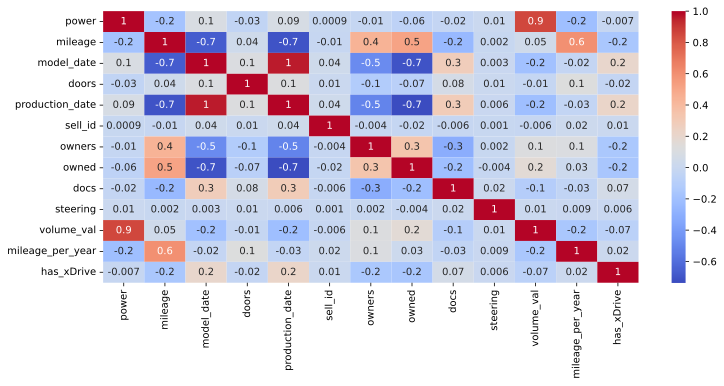

In [42]:
sns.heatmap(data.drop(columns=['price', 'price_log', 'is_train']).corr(),fmt='.1g', annot=True, cmap='coolwarm')

Высокая корреляция между столбцами `model_date` и `production_date` - можно просто выкинуть столбец, например, `model_date`.

In [43]:
data.drop(columns=['model_date'], inplace=True)

In [44]:
# Тут был feature engineering на основе числового столбца `volume`
# Но т.к. его решено было оставить категиальным - код необходимо закомментировать

# ppv = data.power / data.volume # power per volume
# h_power = ppv.quantile(0.9)
# l_power = ppv.quantile(0.1)
# data['h_power'] = (ppv > h_power).astype('int')
# data['l_power'] = (ppv < l_power).astype('int')
# data.h_power.sum(), data.l_power.sum()

проанализируем распределения числовых признаков

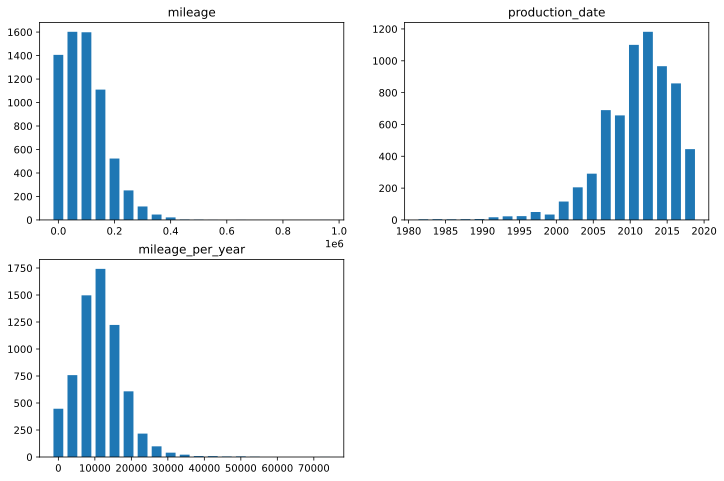

In [45]:
def visualize_distributions(titles_values_dict):
  columns = min(2, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

temp_train = data[data.is_train == 1]
visualize_distributions({
    'mileage': temp_train['mileage'],
    'production_date': temp_train['production_date'],
    'mileage_per_year': temp_train['mileage_per_year']
})

распределения несимметричны, перед обучением моделей необходима нормировка

In [46]:
data.sample(3)

,body_type,brand,color,description,volume,power,fuel,mileage,model_info,doors,production_date,sell_id,transmission,owners,owned,docs,drive,steering,is_train,price,price_log,volume_val,mileage_per_year,has_xDrive
1697,хэтчбек,MERCEDES,серый,«Inchcape Certified- Первый международный офи...,1.6 LTR,122,бензин,160500,B_KLASSE,5,2013,1100024152,роботизированная,2,9.000,1,передний,1,1,757000.0,6.630683,1.6,20062.5,0
8305,внедорожник,MERCEDES,коричневый,Комплект зимней резины в отличном состоянии вх...,3.5 LTR,249,бензин,28000,GLK_KLASSE,5,2013,1099751466,автоматическая,1,6.917,1,полный,1,1,1800000.0,7.496097,3.5,3500.0,0
6482,внедорожник,BMW,чёрный,"продаю личный автомобиль в хорошем состоянии, ...",3.0 LTR,264,бензин,161000,X5,5,2007,1096190840,автоматическая,2,1.583,1,полный,1,1,815000.0,6.704414,3.0,11500.0,0


## Подготовка табличных данных для обучения моделей

In [47]:
# используем все текстовые признаки как категориальные без предобработки
categorical_features = ['body_type', 'brand', 'color', 'volume', 'fuel', 
                        'model_info', 'doors', 'transmission', 'owners', 'drive']

# используем все числовые признаки
numerical_features = ['power', 'mileage', 'production_date', 'owned', 
                      'volume_val', 'mileage_per_year']

In [48]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(columns=['description','sell_id'], inplace=True)
    
    # ################### Numerical Features ############################################################## 
    # Нормализация данных
    # scaler = MinMaxScaler()
    scaler = RobustScaler()  # более устойчива к выбросам, чем MinMaxScaler
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    
    return df_output

In [49]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(5)

,power,mileage,production_date,owned,docs,steering,is_train,price,price_log,volume_val,mileage_per_year,has_xDrive,body_type_0,body_type_1,body_type_2,body_type_3,body_type_4,body_type_5,body_type_6,body_type_7,body_type_8,body_type_9,body_type_10,body_type_11,body_type_12,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,...,model_info_96,model_info_97,model_info_98,model_info_99,model_info_100,model_info_101,model_info_102,model_info_103,model_info_104,model_info_105,model_info_106,model_info_107,model_info_108,model_info_109,model_info_110,model_info_111,model_info_112,model_info_113,model_info_114,model_info_115,model_info_116,model_info_117,model_info_118,model_info_119,model_info_120,model_info_121,doors_0,doors_1,doors_2,doors_3,transmission_0,transmission_1,transmission_2,transmission_3,owners_0,owners_1,owners_2,drive_0,drive_1,drive_2
7564,0.975410,0.970159,-0.857143,1.071429,1,1,1,545000.0,6.302619,1.4,0.309024,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1
5721,1.442623,1.046588,-0.428571,0.642857,1,1,1,673570.0,6.514075,1.6,0.919297,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1
7412,-0.163934,0.803205,-0.428571,0.642857,0,1,1,950000.0,6.857514,-0.8,0.624398,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1
528,-0.385246,0.824505,0.142857,0.071429,1,1,0,0.0,0.000000,-0.8,1.929803,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0
4794,-0.442623,-0.153397,0.285714,-0.071429,1,1,1,1490000.0,7.307202,-0.8,0.343990,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1


In [50]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 232 entries, power to drive_2
dtypes: float64(8), int64(4), uint8(220)
memory usage: 2.5 MB


ниже объявим метод, который на основе переданного дата-сета вернет набор из тренировочных и валидационных дата-сетов, в т.ч. с логарифмом целевой переменной, а так же датасет для вычисления сабмишна

метод необходим, потому что в общем случае мы не обязаны обучать модели ML и DL на одних и тех же данных, можно будет экспериментировать с наборами данных для обучения на каждом из этапов

> *__Спойлер__: по факту лучшие наборы данных и там и там совпадут*

In [51]:
def prepare_train_test(df_input):
    # split train and submission datasets
    train_data = df_input[df_input.is_train == 1].drop(columns='is_train')
    test_data = df_input[df_input.is_train == 0].drop(columns='is_train')
    # pick target feature
    y = train_data.price_log.values     # наш таргет
    y_true = train_data.price.values     # наш таргет для MAPE
    # pick explanatory features
    X = train_data.drop(columns=['price', 'price_log'])
    X_sub = test_data.drop(columns=['price', 'price_log'])
    # split train inot train+test
    X_train, X_val, y_train, y_val, y_true_train, y_true_val = train_test_split(
        X, y, y_true, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)
    
    return X_train, X_val, y_train, y_val, y_true_train, y_true_val, X_sub

## Model 2: CatBoostRegressor

In [52]:
X_train, X_val, y_train, y_val, y_true_train, y_true_val, X_sub = prepare_train_test(
    # df_preproc.drop(columns=['owned', 'volume_val', 'mileage', 'mileage_per_year'])) 
    df_preproc.drop(columns=['owned', 'volume_val', 'mileage'])) # <---- лучший MAPE
    # df_preproc.drop(columns=['owned', 'volume_val']))
    # df_preproc)

In [53]:
md_catboost = CatBoostRegressor(iterations = 10000,
                                #depth=10,
                                #learning_rate = 0.5,
                                random_seed = RANDOM_SEED,
                                eval_metric='MAPE',
                                custom_metric=['RMSE', 'MAE'],
                                od_wait=500,
                                task_type='GPU')

md_catboost.fit(X_train, y_train,
                eval_set=(X_val, y_val),
                verbose_eval=1000,
                use_best_model=True)

Learning rate set to 0.038866
0:	learn: 0.0811456	test: 0.0818377	best: 0.0818377 (0)	total: 12.3ms	remaining: 2m 2s
1000:	learn: 0.0170973	test: 0.0191550	best: 0.0191546 (999)	total: 10.6s	remaining: 1m 35s
2000:	learn: 0.0159361	test: 0.0187133	best: 0.0187133 (2000)	total: 21.3s	remaining: 1m 24s
3000:	learn: 0.0153844	test: 0.0184765	best: 0.0184765 (2999)	total: 31.8s	remaining: 1m 14s
4000:	learn: 0.0149829	test: 0.0182603	best: 0.0182603 (4000)	total: 42.5s	remaining: 1m 3s
5000:	learn: 0.0147432	test: 0.0181159	best: 0.0181159 (5000)	total: 53.1s	remaining: 53.1s
6000:	learn: 0.0145749	test: 0.0180342	best: 0.0180342 (6000)	total: 1m 3s	remaining: 42.4s
7000:	learn: 0.0144185	test: 0.0179455	best: 0.0179455 (7000)	total: 1m 14s	remaining: 31.9s
8000:	learn: 0.0142324	test: 0.0178329	best: 0.0178328 (7989)	total: 1m 25s	remaining: 21.3s
9000:	learn: 0.0140811	test: 0.0177576	best: 0.0177567 (8999)	total: 1m 35s	remaining: 10.6s
9999:	learn: 0.0139587	test: 0.0176806	best: 0.017

In [54]:
y_pred_catboost = predict_price(md_catboost.predict(X_val))
print(f"TEST mape: {(mape(y_true_val, y_pred_catboost))*100:0.2f}%")

TEST mape: 12.81%


Валидационный MAPE лучшего kaggle score **12.81%**

### Submission

In [55]:
sub_predict_catboost = predict_price(md_catboost.predict(X_sub))
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

In [56]:
# !kaggle competitions submit -c sf-dst-car-price-prediction-part2 -f catboost_submission.csv -m "catboost only, more columns" 

kaggle score = **13.22920**

Это будет наш персональный бейслайн, который предстоит улучшать

## Model 3: Tabular NN

### Simple Dense NN

In [57]:
# для обучения НН будем использовать свой собственный дата-сет, имеем право!
X_train, X_val, y_train, y_val, y_true_train, y_true_val, X_sub = prepare_train_test(
    # df_preproc.drop(columns=['owned', 'volume_val', 'mileage', 'mileage_per_year'])) # 13.42
    df_preproc.drop(columns=['owned', 'volume_val', 'mileage'])) # 11.93
    # df_preproc.drop(columns=['owned', 'volume_val'])) # 11.97
    # df_preproc) # 11.99

md_dense = Sequential()
md_dense.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
# md_dense.add(L.BatchNormalization())
md_dense.add(L.Dropout(0.5))
md_dense.add(L.Dense(256, activation="relu"))
md_dense.add(L.Dense(256, activation="relu"))
md_dense.add(L.Dropout(0.5))
md_dense.add(L.Dense(1, activation="linear"))

In [58]:
md_dense.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               116224    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 313,601
Trainable params: 313,601
Non-trai

In [59]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
md_dense.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [60]:
checkpoint = ModelCheckpoint(MODEL_PATH + 'best_md_dense.hdf5', 
                             monitor='val_MAPE', 
                             verbose=0,
                             mode='min', 
                             save_best_only=True)
earlystop = EarlyStopping(monitor='val_MAPE', 
                          patience=50, 
                          restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_MAPE', 
#                               factor=0.1, 
#                               mode='min',
#                               patience=20, 
#                               min_lr=0.0001)
callbacks_list = [checkpoint, earlystop] #, reduce_lr]

In [61]:
%%time
history = md_dense.fit(X_train, y_true_train,
# history = md_dense.fit(X_train, y_train,
                       batch_size=512,
                       epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                       validation_data=(X_val, y_true_val),
                    #    validation_data=(X_val, y_val),
                       callbacks=callbacks_list,
                       verbose=0)

CPU times: user 18.9 s, sys: 1.97 s, total: 20.9 s
Wall time: 18.2 s


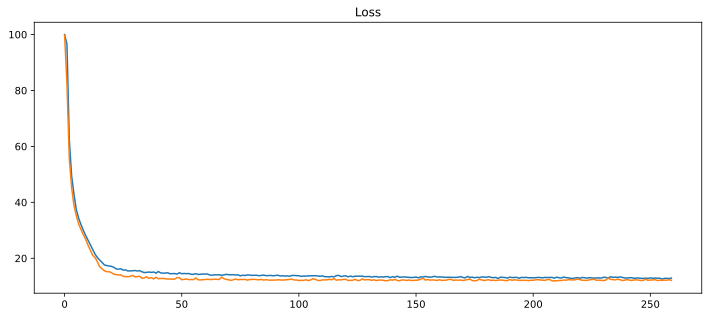

In [62]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [63]:
md_dense.load_weights(MODEL_PATH + 'best_md_dense.hdf5')
md_dense.save(MODEL_PATH + 'nn_1.hdf5')

In [119]:
y_pred_dense = 1000 * np.round(md_dense.predict(X_val)[:,0] / 1000)
# y_pred_dense = predict_price(md_dense.predict(X_val)[:,0])
print(f"TEST mape: {(mape(y_true_val, y_pred_dense))*100:0.2f}%")

TEST mape: 11.92%


In [116]:
sub_predict_nn1 = 1000 * np.round(md_dense.predict(X_sub)[:,0] / 1000)
# sub_predict_nn1 = predict_price(md_dense.predict(X_sub)[:,0])
sample_submission['price'] = sub_predict_nn1
sample_submission.to_csv('dense_submission.csv', index=False)

In [66]:
# !kaggle competitions submit -c sf-dst-car-price-prediction-part2 -f dense_submission.csv -m "dense, more layers, no BN, all columns" 

**Попытка 1** НН из бейслайна (ННБ):
* логарифм цены - 13.09443 (test MAPE 12.85)
* без логарифмов цен - 11.89845 (test MAPE 11.95-11.99)

**Попытка 2** попытка 1 + доп. полносвязный слой без логарифмов - test MAPE 11.82

**Попытка 3** попытка 2 + `sigmoid` вместо `relu` - test MAPE 11.85

**Попытка 4** попытка 2 + слой `BatchNormalization` - test MAPE 11.77 - 11.79

**Попытка 5** архитектура полносвязных слоев 1024 - 512 - 256, коэф dropout 0.25 - test MAPE 11.90

**Попытка 100500** архитектура `512-256-256`, везде `relu`, без `BatchNormalization`, все числовые признаки включены - **11.75849** (test MAPE 11.65-11.88)

## Model 4: NLP + Multiple Inputs

In [60]:
!pip install -q pymorphy2 pymorphy2-dicts

     |████████████████████████████████| 55 kB 2.2 MB/s 
     |████████████████████████████████| 7.1 MB 6.4 MB/s 
     |████████████████████████████████| 8.2 MB 62.0 MB/s 


In [61]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
data_NLP = data.copy()

In [62]:
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"

def tokenize_str(s):
    s = re.sub(patterns, ' ', s)
    tokens = []
    for token in s.split():
        token = token.strip()
        token = morph.normal_forms(token)[0]
        tokens.append(token)
    return ' '.join(tokens)

In [63]:
data_NLP.description = data_NLP.description.apply(tokenize_str)

In [64]:
data_NLP.description.sample(5)

4144    выгода до руб при обмен на ваш автомобиль выго...
2819    звонить всё рассказать много что сделать грм п...
3559    асц честно «автоспеццентр» химки – это широкий...
5354    самый полный комплектация есть даже автопарков...
5859    музыка хармона м пакет внутренний и внешний нб...
Name: description, dtype: object

In [65]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [66]:
# split данных
text_train = data_NLP.description.iloc[X_train.index]
text_val = data_NLP.description.iloc[X_val.index]
text_sub = data_NLP.description.iloc[X_sub.index]

### Tokenizer

In [67]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data_NLP.description)

CPU times: user 1.04 s, sys: 6.5 ms, total: 1.05 s
Wall time: 1.05 s


In [68]:
# tokenize.word_index
# works, too long output

In [69]:
%%time
text_train_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_val_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_val), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_val_sequences.shape, text_sub_sequences.shape)

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 983 ms, sys: 6.37 ms, total: 989 ms
Wall time: 996 ms


In [70]:
# вот так теперь выглядит наш текст
print(text_train.iloc[RANDOM_SEED])
print(text_train_sequences[RANDOM_SEED])

я владелец птс оригинал технически в хороший состояние электроника весь работать салон не прокурить сам не курить иметься незначительный скол по кузов пробег родный любой проверка за ваш счёт торг непосредственно у капот автосалон не звонить сообщение «купля за » не присылать дополнительно ответить по телефон
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0

### RNN NLP

In [78]:
md_nlp = Sequential()
md_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
md_nlp.add(L.Embedding(len(tokenize.word_index) + 1, MAX_SEQUENCE_LENGTH))
md_nlp.add(L.LSTM(256, return_sequences=True))
md_nlp.add(L.Dropout(0.5))
md_nlp.add(L.Dense(64, activation="relu")) # <-- added 
md_nlp.add(L.LSTM(128,))
md_nlp.add(L.Dropout(0.25))
md_nlp.add(L.Dense(64, activation="relu"))
md_nlp.add(L.Dropout(0.25))

### MLP

In [79]:
md_mlp = Sequential()
md_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
md_mlp.add(L.Dropout(0.5))
md_mlp.add(L.Dense(256, activation="relu"))
md_mlp.add(L.Dense(256, activation="relu"))
md_mlp.add(L.Dropout(0.5))
md_mlp.add(L.Dense(1, activation="linear"))

md_mlp.load_weights(MODEL_PATH + 'nn_1.hdf5') # <--- transfer learning

### Multiple Inputs NN

In [80]:
# combinedInput = L.concatenate([md_nlp.output, md_mlp.output])
combinedInput = L.concatenate([md_nlp.output, md_mlp.layers[-1].output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

md_multi = Model(inputs=[md_nlp.input, md_mlp.input], outputs=head)

In [81]:
md_multi.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq_description (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 256, 256)     3673856     ['seq_description[0][0]']        
                                                                                                  
 lstm (LSTM)                    (None, 256, 256)     525312      ['embedding[0][0]']              
                                                                                                  
 dense_6_input (InputLayer)     [(None, 226)]        0           []                               
                                                                                              

### Fit

In [82]:
optimizer = tf.keras.optimizers.Adam(0.01)
md_multi.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [83]:
# снова создадим коллбэки для обучения
checkpoint = ModelCheckpoint(MODEL_PATH + 'best_md_multi.hdf5', 
                             monitor='val_MAPE', 
                             verbose=0,
                             mode='min', 
                             save_best_only=True)
earlystop = EarlyStopping(monitor='val_MAPE', 
                          patience=50, 
                          restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_MAPE', 
#                               factor=0.1, 
#                               mode='min',
#                               patience=20, 
#                               min_lr=0.0001)
callbacks_list = [checkpoint, earlystop] #, reduce_lr]

In [84]:
%%time
history = md_multi.fit([text_train_sequences, X_train], y_true_train, # даже не будем пытаться обучиться на логарифмах
                       batch_size=512,
                       epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                       validation_data=([text_val_sequences, X_val], y_true_val),
                       callbacks=callbacks_list,
                       verbose=0,
                       )

CPU times: user 1min 26s, sys: 2.56 s, total: 1min 29s
Wall time: 2min 4s


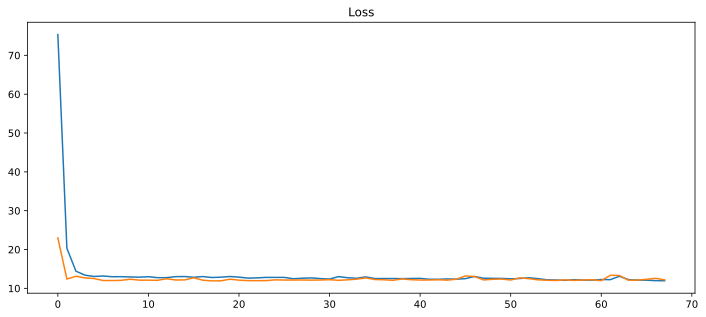

In [85]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [86]:
md_multi.load_weights(MODEL_PATH + 'best_md_multi.hdf5')
md_multi.save(MODEL_PATH + 'nn_mlp_nlp.hdf5')

In [ ]:
y_pred_nn2 = 1000 * np.round(md_multi.predict([text_val_sequences, X_val]) / 1000)
print(f"TEST mape: {(mape(y_true_val, y_pred_nn2[:,0]))*100:0.2f}%")

* **Попыка 1** бейслайн - test MAPE 11.92
* **Попыка 2** MLP из бейслайна + обработка текста - test MAPE 11.77
* **Попыка 3** попытка 2 + 1 полносвязный слой 128 нейронов - test MAPE 11.81
* **Попыка 4** попытка 2 + 1 полносвязный слой 64 нейрона + дропаут 0.5 - test MAPE 11.89
* **Попыка 5** попытка 2 + 1 полносвязный слой 64 нейронов - test MAPE 11.72-11.76


In [88]:
sub_predict_nn2 = md_multi.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

In [89]:
!kaggle competitions submit -c sf-dst-car-price-prediction-part2 -f nn2_submission.csv -m "NLP + MLP + transfer learning" 

100% 34.0k/34.0k [00:05<00:00, 6.83kB/s]
Successfully submitted to [SF-DST] Car Price prediction Part2

лучший kaggle score **11.77384**, почему-то добавление NLP не привело к улучшению метрики.

## Model 5: Добавляем картинки

### Data

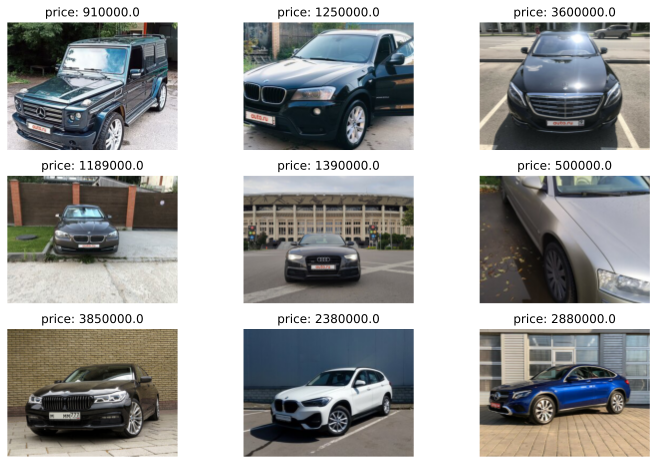

In [71]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [90]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_val = get_image_array(X_val.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

In [91]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4,
                          always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=224, width=200),
        albumentations.CenterCrop(height=200, width=224),
    ], p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.1, contrast_limit=0.1)
    ], p=0.5),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.Resize(240, 320)
])

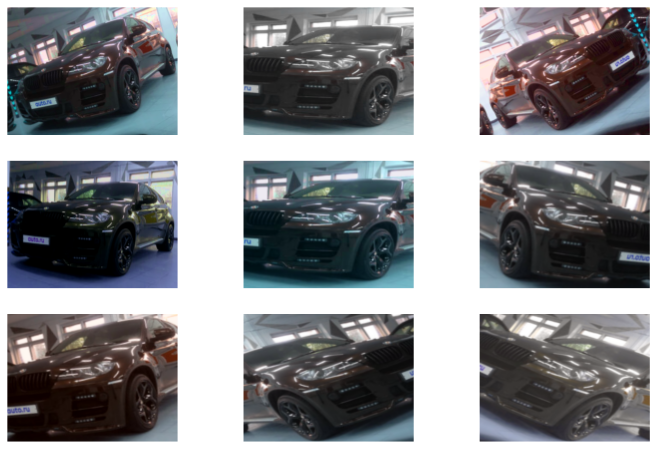

In [92]:
#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = AUGMENTATIONS(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [93]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

In [94]:
# NLP part
# tokenize = Tokenizer(num_words=MAX_WORDS)
# tokenize.fit_on_texts(data_NLP['description'])

# используем токенизатор из предыдущего раздела

In [95]:
def process_image(image):
    return AUGMENTATIONS(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, text_train, y_true_train
    )).map(tf_process_train_dataset_element)

val_dataset = tf.data.Dataset.from_tensor_slices((
    images_val, X_val, text_val, y_true_val
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, text_sub, y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
val_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### CNN без "головы"

In [96]:
# из прошлого проекта я возьму EfficientNetB7, т.к. она показала себя лучше, чем B3
# нормализация включена в состав модели EfficientNetB7, поэтому на вход она принимает данные типа uint8
# а еще в ее состав входит пулинг, если в конструкторе указать спец параметр pooling
md_effnet = tf.keras.applications.efficientnet.EfficientNetB7(weights = 'imagenet', 
                                                              include_top = False,
                                                              pooling='avg',
                                                              input_shape = (size[1], size[0], 3))
# efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

258088960/258076736 [==============================] - 3s 0us/step


In [126]:
# воссоздаем модель из предыдущего раздела для анализа табличных данных
md_mlp = Sequential()
md_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
md_mlp.add(L.Dropout(0.5))
md_mlp.add(L.Dense(256, activation="relu"))
md_mlp.add(L.Dense(256, activation="relu"))
md_mlp.add(L.Dropout(0.5))
md_mlp.add(L.Dense(1, activation="linear")) # <--- transfer learning

md_mlp.load_weights('nn_1.hdf5') # <--- transfer learning

In [125]:
# NLP
# воссоздаем NLP модель из предыдущего раздела
md_nlp = Sequential()
md_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
md_nlp.add(L.Embedding(len(tokenize.word_index) + 1, MAX_SEQUENCE_LENGTH))
md_nlp.add(L.LSTM(256, return_sequences=True))
md_nlp.add(L.Dropout(0.5))
md_nlp.add(L.Dense(64, activation="relu")) # <-- added 
md_nlp.add(L.LSTM(128,))
md_nlp.add(L.Dropout(0.25))
md_nlp.add(L.Dense(64, activation="relu"))
md_nlp.add(L.Dropout(0.25))

In [97]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([md_effnet.output, md_mlp.layers[-1].output, md_nlp.output])  # <--- transfer learning
#combinedInput = L.concatenate([md_effnet.output, md_mlp.output, md_nlp.output]) 

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

md_tripple = Model(inputs=[md_effnet.input, md_mlp.input, md_nlp.input], outputs=head)
md_tripple.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 240, 320, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 240, 320, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 241, 321, 3)  0           ['normalization[0][0]']    

In [98]:
optimizer = tf.keras.optimizers.Adam(0.005)
md_tripple.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [99]:
# снова создадим коллбэки для обучения
checkpoint = ModelCheckpoint(MODEL_PATH + 'best_md_tripple.hdf5', 
                             monitor='val_MAPE', 
                             verbose=0,
                             mode='min', 
                             save_best_only=True)
earlystop = EarlyStopping(monitor='val_MAPE', 
                          patience=10, 
                          restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_MAPE', 
#                               factor=0.1, 
#                               mode='min',
#                               patience=20, 
#                               min_lr=0.0001)
callbacks_list = [checkpoint, earlystop] #, reduce_lr]

In [ ]:
history = md_tripple.fit(train_dataset.batch(10),
                         epochs=100,
                         validation_data = val_dataset.batch(10),
                         callbacks=callbacks_list,
                         verbose=1
                         )

In [103]:
# модель обучалась некоторое время, но была остановлена руками
# подгрузим лучшую ее версию и немного подкрутим процесс обучения
md_tripple.load_weights(MODEL_PATH + 'best_md_tripple.hdf5')
optimizer = tf.keras.optimizers.Adam(0.01)
md_tripple.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])
checkpoint = ModelCheckpoint(MODEL_PATH + 'best_md_tripple.hdf5', 
                             monitor='val_MAPE', 
                             verbose=0,
                             mode='min', 
                             save_best_only=True)
earlystop = EarlyStopping(monitor='val_MAPE', 
                          patience=10, 
                          restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_MAPE', 
                              factor=0.1, 
                              mode='min',
                              patience=5, 
                              min_lr=0.0001)
callbacks_list = [checkpoint, earlystop, reduce_lr]

In [104]:
history = md_tripple.fit(train_dataset.batch(10),
                         epochs=100,
                         validation_data = val_dataset.batch(10),
                         callbacks=callbacks_list,
                         verbose=1
                         )

Epoch 1/100
568/568 [==============================] - ETA: 0s - loss: 14.2736 - MAPE: 14.2736

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


568/568 [==============================] - 457s 729ms/step - loss: 14.2736 - MAPE: 14.2736 - val_loss: 13.9620 - val_MAPE: 13.9620 - lr: 0.0100
Epoch 2/100
568/568 [==============================] - 411s 723ms/step - loss: 14.2058 - MAPE: 14.2058 - val_loss: 12.4665 - val_MAPE: 12.4665 - lr: 0.0100
Epoch 3/100
568/568 [==============================] - 396s 698ms/step - loss: 14.2921 - MAPE: 14.2921 - val_loss: 12.9182 - val_MAPE: 12.9182 - lr: 0.0100
Epoch 4/100
568/568 [==============================] - 397s 699ms/step - loss: 14.4574 - MAPE: 14.4574 - val_loss: 12.8965 - val_MAPE: 12.8965 - lr: 0.0100
Epoch 5/100
568/568 [==============================] - 397s 698ms/step - loss: 14.0409 - MAPE: 14.0409 - val_loss: 12.7151 - val_MAPE: 12.7151 - lr: 0.0100
Epoch 6/100
568/568 [==============================] - 397s 698ms/step - loss: 14.2054 - MAPE: 14.2054 - val_loss: 14.5541 - val_MAPE: 14.5541 - lr: 0.0100
Epoch 7/100
568/568 [==============================] - 396s 697ms/step - los

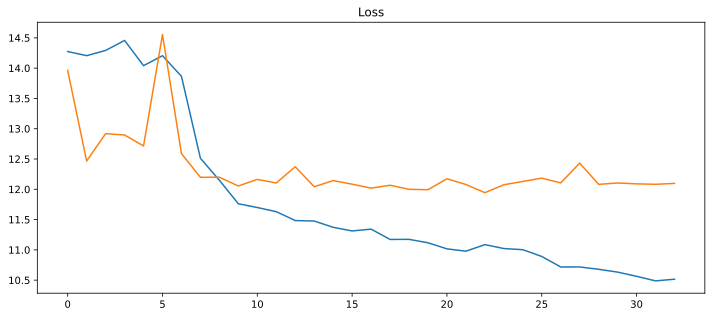

In [105]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

модель ощутимо переобучилась, и даже постепенное снижение LR в процессе обучения не помогло это исправить

In [107]:
md_tripple.load_weights(MODEL_PATH + 'best_md_tripple.hdf5')
md_tripple.save(MODEL_PATH + 'nn_final.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [109]:
y_pred_nn3 = 1000 * np.round(md_tripple.predict(val_dataset.batch(10))[:,0] / 1000)
print(f"TEST mape: {(mape(y_true_val, y_pred_nn3))*100:0.2f}%")

TEST mape: 11.95%


* **Попытка 1** обучение с нуля - test MAPE 12.53
* **Попытка 2** transfer learning - test MAPE 11.95

In [112]:
sub_predict_nn3 = 1000 * np.round(md_tripple.predict(sub_dataset.batch(10))[:,0] / 1000)
sample_submission['price'] = sub_predict_nn3
sample_submission.to_csv('nn3_submission.csv', index=False)

In [113]:
# !kaggle competitions submit -c sf-dst-car-price-prediction-part2 -f nn3_submission.csv -m "IMG + NLP + MLP + transfer learning" 

100% 33.7k/33.7k [00:04<00:00, 8.00kB/s]
Successfully submitted to [SF-DST] Car Price prediction Part2

kaggle score **11.81828**

Несмотря на все старания, улучшить результат простой полносвязной сети не удалось(((

## Blend

In [128]:
blend_sub_predict = (sub_predict_nn1 + sub_predict_nn2[:,0] + sub_predict_nn3) / 3
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

In [129]:
# !kaggle competitions submit -c sf-dst-car-price-prediction-part2 -f blend_submission.csv -m "blend nn1, nn2, nn3" 

100% 34.0k/34.0k [00:04<00:00, 8.00kB/s]
Successfully submitted to [SF-DST] Car Price prediction Part2

kaggle score **11.64974** 

Blend wins! Flawless victory!

## Выводы

В ходе выполнения работы были на практике применены навки в построении и обучении следующих типов НС:
* последовательная НС для табличных данных
* рекуррентная НС для NLP
* сверточная НС для анализа изображений
* мульти-инпутная НС

Также использовалось:
* transfer learning
* библиотеки очистки и упрощения текста (`pymorphy2')
* продвинутые библиотеки аугментации изображений ('albumentations)
* методы бэггинга (в частности, простое усреднение предсказаний 3 НС)

Цель работы достигнута, наилучшее значение kaggle score, которого удалось добиться - **11.64974**